# Land Use/Land Cover

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

import pygeohydro as gh
from pynhd import NLDI

Land cover, imperviousness, and canopy data can be retrieved from the [NLCD](https://www.mrlc.gov/data) database. First, we use [PyNHD](https://github.com/cheginit/pynhd) to get the contributing watershed geometry of three NWIS stations with the ID of `USGS-01031450`, `USGS-01031500`, and `USGS-01031510`:

In [2]:
station_ids = ["01031450", "01318500", "01031510", "03460000"]
geometry = NLDI().get_basins(station_ids)
geometry.index = station_ids

We can now use the ``nlcd_bygeom`` and ``nlcd_bycoords`` functions to get the NLCD data.

Let's start by ``nlcd_bygeom``. This function has two positional arguments for passing the target geometries or points of interests and target resolution in meters. Note that, if a single geometry is passed and the geometry is not in ``EPSG:4326`` CRS, ``geo_crs`` argument should be given as well. The second argument is the target resolution of the data in meters. The NLCD database is multi-resolution and based on the target resolution, the source data are resampled on the server side.

You should be mindful of the resolution since higher resolutions require more memory so if your requests requires more memory than the available memory on your system the code is likely to crash. You can either increase the resolution or divide your region of interest into smaller regions.

Moreover, the [MRLC](https://www.mrlc.gov/geoserver/web/) GeoServer has a limit of about 8 million pixels per request but PyGeoHydro takes care of the domain decomposition under-the-hood and divides the request to smaller requests then merges them. So the only bottleneck for requests is the amount of available memory on your system.

Both ``nlcd_bygeom`` and ``nlcd_bycoords`` functions can request for four layers from the MRLC web service; imperviousness, land use/land cover, impervious descriptors, and tree canopy. Since NLCD is released every couple of years, you can specify the target year via the ``years`` argument. Layers that are not included in this argument are ignored. By default, `years` is `{'impervious': [2019], 'cover': [2019], 'canopy': [2019], 'descriptor': [2019]}`.

Furthermore, we can specify the region of interest as well via the `region` argument. Valid values are `L48` (for CONUS), `HI` (for Hawaii), `AK` (for Alaska), and `PR` (for Puerto Rico). By default, region is set to `L48`.

Let's get the cover and impervious descriptor data at a 100 m resolution for all three stations

In [3]:
desc = gh.nlcd_bygeom(geometry, 100, years={"descriptor": 2019}, ssl=False)

This function returns a `dict` where its keys are the indices of the input `GeoDataFrame`.

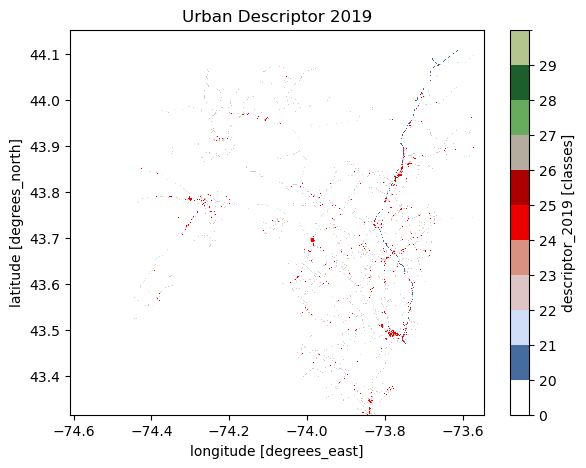

In [4]:
cmap, norm, levels = gh.plot.descriptor_legends()

desc_2019 = desc["01318500"].descriptor_2019
ax = desc_2019.where(desc_2019 < 127).plot(
    size=5, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]}
)
ax.axes.set_title("Urban Descriptor 2019")
ax.figure.savefig("_static/descriptor.png", bbox_inches="tight", facecolor="w")

Now let's get the land cover data:

In [5]:
lulc = gh.nlcd_bygeom(geometry, 100, years={"cover": [2016, 2019]}, ssl=False)

Moreover, we can get the statistics of the cover data for each class or category:

In [6]:
stats = gh.cover_statistics(lulc["01318500"].cover_2019)
stats

Stats(classes={'Open Water': np.float64(3.232103471561223), 'Developed, Open Space': np.float64(1.608446244154719), 'Developed, Low Intensity': np.float64(0.5441383554161471), 'Developed, Medium Intensity': np.float64(0.27195394298646913), 'Developed, High Intensity': np.float64(0.04010168311834375), 'Barren Land (Rock/Sand/Clay)': np.float64(0.09403153282921983), 'Deciduous Forest': np.float64(41.68800429595042), 'Evergreen Forest': np.float64(29.4134322200891), 'Mixed Forest': np.float64(14.09366739110895), 'Shrub/Scrub': np.float64(0.7531741404065941), 'Grassland/Herbaceous': np.float64(0.5268531471754817), 'Pasture/Hay': np.float64(0.4667006224979661), 'Cultivated Crops': np.float64(0.00967971661477263), 'Woody Wetlands': np.float64(6.661027847622823), 'Emergent Herbaceous Wetlands': np.float64(0.5966853884677701)}, categories={'Water': np.float64(3.232103471561223), 'Developed': np.float64(2.4646402256756788), 'Barren': np.float64(0.09403153282921983), 'Forest': np.float64(85.1951

and an estimation of the overland roughness:

In [7]:
roughness = gh.overland_roughness(lulc["01318500"].cover_2019)

Additionally, `PyGeoHydro` provides a function for getting the official legends of the cover data. Let's plot the data using this legends.

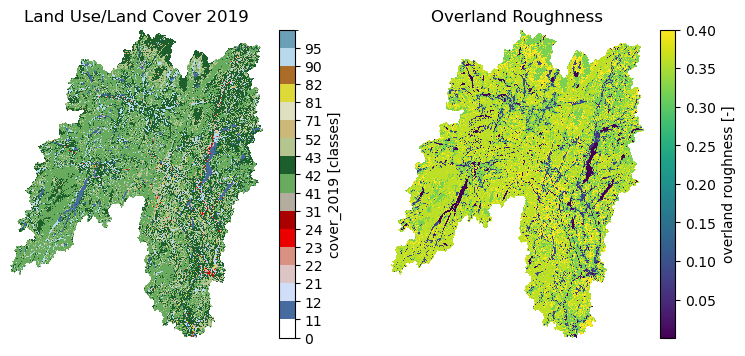

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

cmap, norm, levels = gh.plot.cover_legends()
cover = lulc["01318500"].cover_2019
cover.where(cover < 127).plot(ax=ax1, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
ax1.set_title("Land Use/Land Cover 2019")
ax1.set_axis_off()

roughness.plot(ax=ax2)
ax2.set_title("Overland Roughness")
ax2.set_axis_off()
fig.savefig(Path("_static", "lulc.png"), bbox_inches="tight", facecolor="w")

Now, let's see `nlcd_bycoords` in action. The coordinates must be a list of (longitude, latitude) coordinates. Let's use [osmnx](https://github.com/gboeing/osmnx) package to get a street network:

In [9]:
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")

Now, we can get land cover and tree canopy for each node based on their coordinates and then plot the results. 

In [10]:
x, y = nx.get_node_attributes(G, "x").values(), nx.get_node_attributes(G, "y").values()
lulc = gh.nlcd_bycoords(list(zip(x, y)), years={"cover": [2019], "canopy": [2016]})
nx.set_node_attributes(G, dict(zip(G.nodes(), lulc.cover_2019)), "cover_2019")
nx.set_node_attributes(G, dict(zip(G.nodes(), lulc.canopy_2016)), "canopy_2016")

In [11]:
lulc.head()

,geometry,cover_2019,canopy_2016
0,POINT (-122.2476 37.82625),23,27.0
1,POINT (-122.24719 37.82422),22,21.0
2,POINT (-122.24611 37.8249),23,20.0
3,POINT (-122.24534 37.82541),23,24.0
4,POINT (-122.24447 37.82595),23,25.0


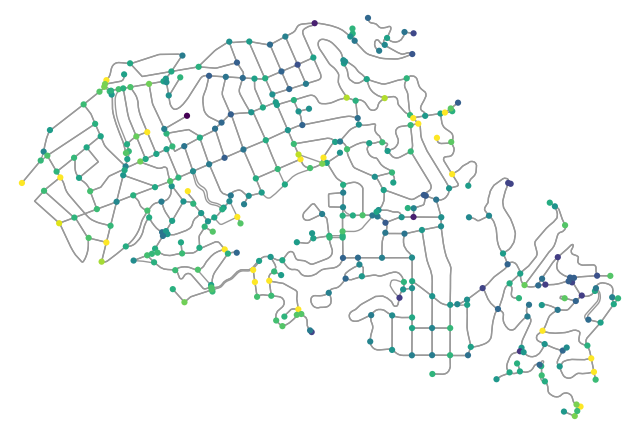

In [12]:
nc = ox.plot.get_node_colors_by_attr(G, "canopy_2016", cmap="viridis_r")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=20,
    save=True,
    bgcolor="w",
)

Next, let's get the data for a larger area at a coarser resolution. For example, we get the Upper Hudson subregion boundary using `pygeohydro.WBD`, then get the cover data within the area.

In [13]:
wbd = gh.WBD("huc4")
hud = wbd.byids("huc4", ["0202", "0203", "0204", "0205", "0206", "0207", "0208"])
hud = hud.set_index("huc4")
lulc = gh.nlcd_bygeom(hud, 1000, years={"cover": [2019]})

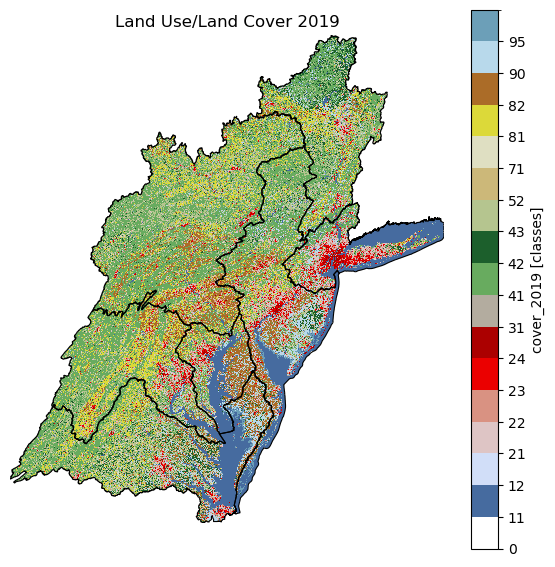

In [14]:
cmap, norm, levels = gh.plot.cover_legends()
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
xmin, ymin, xmax, ymax = hud.total_bounds

cover = {h: da.cover_2019.where(da.cover_2019 < 127) for h, da in lulc.items()}

cover["0202"].plot(ax=ax, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
_ = cover.pop("0202")
for da in cover.values():
    da.plot(ax=ax, cmap=cmap, levels=levels, add_colorbar=False)
hud.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=0.8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_axis_off()
ax.set_title("Land Use/Land Cover 2019")
ax.margins(0)